In [36]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from loguru import logger

from epsilon_strategy import ConstantEpsilon, DecreasingEpsilon
from network import DQN
from optimal_player import OptimalPlayer
from policy import EpsilonGreedy
from replay_memory import ReplayMemory
from tic_env import TictactoeEnv
from trainer import Trainer
from utils import represent_gird_as_state

logger.remove()
logger.add(sys.stderr, level="INFO")
from self_trainer import SelfPracticeTrainer
import seaborn as sns
sns.set()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
np.random.seed(1)
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Implement the DQN algorithm. To check the algorithm, run a DQN agent with a fixed and arbitrary ε ∈ [0, 1) against Opt(0.5) for 20’000 games – switch the 1st player after every game.
Question 11. Plot average reward and average training loss for every 250 games during training. Does the loss decrease? Does the agent learn to play Tic Tac Toe?
Expected answer: A figure with two subplots (caption length < 50 words). Specify your choice of ε.

In [4]:
opponent_epsilon = 0.5
agent_epsilon = 0.2
dqn = DQN(device).to(device)
replay_memory = ReplayMemory(10_000, 64)
trainer = Trainer(
    dqn,
    OptimalPlayer(opponent_epsilon),
    EpsilonGreedy(dqn, ConstantEpsilon(agent_epsilon), 9, device, logger),
    replay_memory,
)

In [5]:
trainer.main_loop(calculate_ms=False)

2022-06-06 20:54:01.412 | INFO     | trainer:main_loop:111 - Initialize Replay Memory: Started
  0%|          | 0/64 [00:00<?, ?it/s]2022-06-06 20:54:01.492 | INFO     | trainer:main_loop:188 - Initialize Replay Memory: Done
2022-06-06 20:54:01.493 | INFO     | trainer:main_loop:189 - Training Loop: Start
100%|██████████| 64/64 [00:00<00:00, 951.02it/s]
20001it [02:22, 140.17it/s]                           
2022-06-06 20:56:24.189 | INFO     | trainer:main_loop:217 - Training Loop: Done


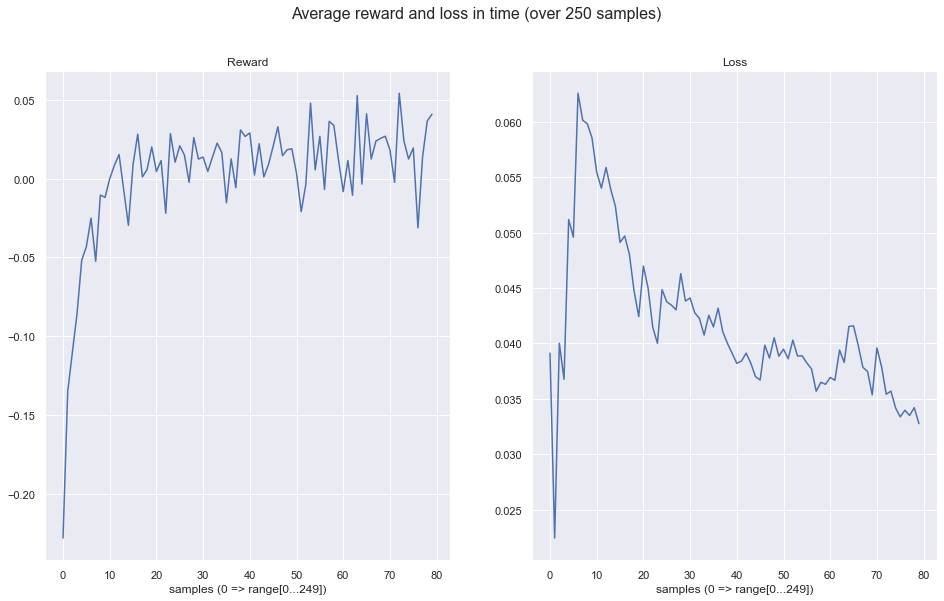

In [6]:
trainer.plot_avg_loss_reward("question11_reward_and_loss.png")

Question 12. Repeat the training but without the replay buffer and with a batch size of 1: At every step, update the network by using only the latest transition. What do you observe?
Expected answer: A figure with two subplots showing average reward and average training loss during training (caption length < 50 words).

In [7]:
# by setting the replay memory to 1 we achieve the same results
opponent_epsilon = 0.5
agent_epsilon = 0.2
dqn =DQN(device).to(device)
batch_size = 1
replay_memory = ReplayMemory(1, 1)
trainer_batch_one = Trainer(
    dqn,
    OptimalPlayer(opponent_epsilon),
    EpsilonGreedy(dqn, ConstantEpsilon(agent_epsilon), 9, device, logger),
    replay_memory,
    batch_size=batch_size
)

In [9]:
trainer_batch_one.main_loop()

2022-06-06 21:02:26.757 | INFO     | trainer:main_loop:111 - Initialize Replay Memory: Started
  0%|          | 0/1 [00:00<?, ?it/s]2022-06-06 21:02:26.763 | INFO     | trainer:main_loop:188 - Initialize Replay Memory: Done
2022-06-06 21:02:26.763 | INFO     | trainer:main_loop:189 - Training Loop: Start
100%|██████████| 1/1 [00:00<00:00, 215.90it/s]
20001it [04:51, 68.56it/s]                            
2022-06-06 21:07:18.487 | INFO     | trainer:main_loop:217 - Training Loop: Done


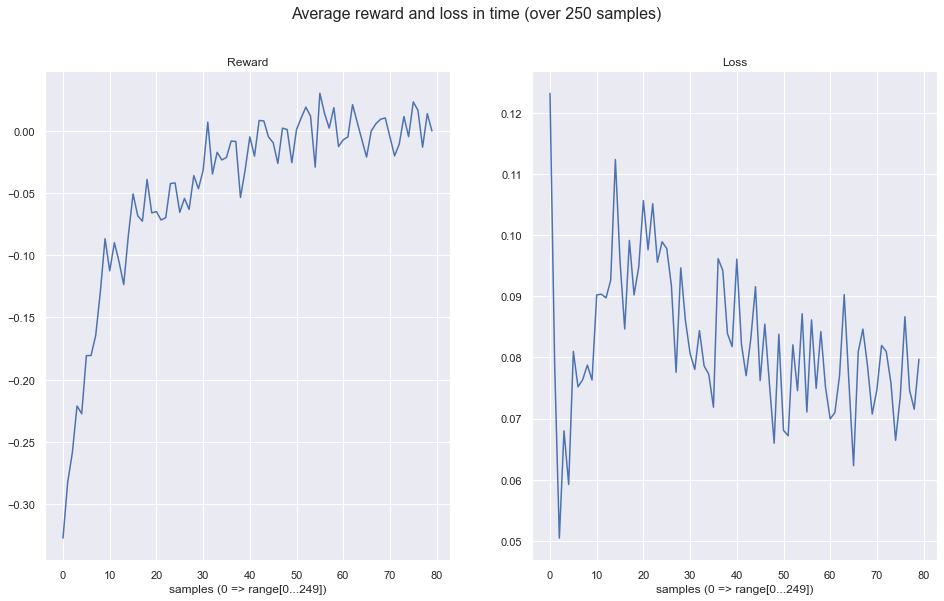

In [11]:
trainer_batch_one.plot_avg_loss_reward("question12_reward_and_loss.png")

Instead of fixing ε, use ε(n) in Equation 1. For different values of n∗, run your DQN against Opt(0.5) for 20’000 games – switch the 1st player after every game. Choose several values of n∗ from a reasonably wide interval between 1 to 40’000 – particularly, include n∗ = 1.

In [20]:
n_stars = np.linspace(1, 40_000, 5).astype(np.int32)
n_stars

array([    1, 10000, 20000, 30000, 40000], dtype=int32)

In [23]:
n_star_trainers = []
for n_star in n_stars:
    opponent_epsilon = 0.5
    agent_epsilon = 0.1
    dqn =DQN(device).to(device)
    batch_size = 64
    replay_memory = ReplayMemory(10_000, 64)
    temp_trainer = Trainer(
        dqn,
        OptimalPlayer(opponent_epsilon),
        EpsilonGreedy(dqn, DecreasingEpsilon(0.1, 0.8, n_star), 9, device, logger),
        replay_memory,
        batch_size=batch_size
    )
    n_star_trainers.append(temp_trainer)


In [24]:
for t in n_star_trainers:
    t.main_loop()

2022-06-06 21:15:44.484 | INFO     | trainer:main_loop:111 - Initialize Replay Memory: Started
  0%|          | 0/64 [00:00<?, ?it/s]2022-06-06 21:15:44.545 | INFO     | trainer:main_loop:188 - Initialize Replay Memory: Done
2022-06-06 21:15:44.546 | INFO     | trainer:main_loop:189 - Training Loop: Start
  1%|▏         | 251/20000 [02:29<3:15:49,  1.68it/s]
20001it [05:18, 62.82it/s]                            
2022-06-06 21:21:02.951 | INFO     | trainer:main_loop:217 - Training Loop: Done
2022-06-06 21:21:02.952 | INFO     | trainer:main_loop:111 - Initialize Replay Memory: Started
  0%|          | 0/64 [00:00<?, ?it/s]2022-06-06 21:21:02.995 | INFO     | trainer:main_loop:188 - Initialize Replay Memory: Done
2022-06-06 21:21:02.996 | INFO     | trainer:main_loop:189 - Training Loop: Start
100%|██████████| 64/64 [00:00<00:00, 1510.26it/s]
20001it [04:54, 67.95it/s]                            
2022-06-06 21:25:57.353 | INFO     | trainer:main_loop:217 - Training Loop: Done
2022-06-06

Question 13. After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents. Plot Mopt and Mrand over time. Does decreasing ε help training compared to having a fixed ε? What is the effect of n∗?
Expected answer: A figure showing Mopt and Mrand over time for different values of speeds of n∗ (caption length < 250 words).

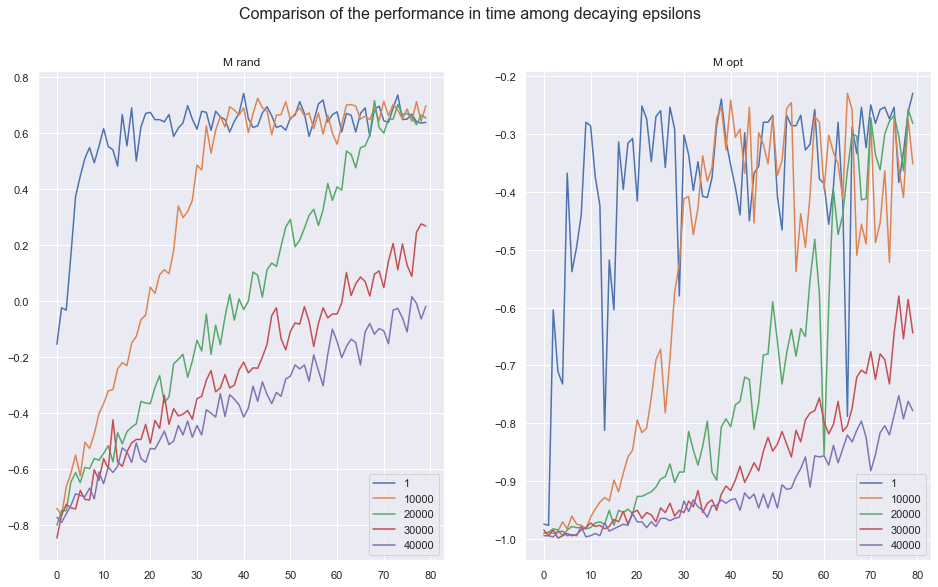

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.suptitle("Comparison of the performance in time among decaying epsilons", fontsize=16)
ax1.set_title("M rand")
ax2.set_title("M opt")
for n_star, t in zip(n_stars, n_star_trainers):
    ax1.plot(list(range(len(t.m_rand))), t.m_rand, label=str(n_star))
    ax1.legend()
    ax2.plot(list(range(len(t.m_opt))), t.m_opt, label=str(n_star))
    ax2.legend()
f.savefig("./../pictures/question13_mrand_mopt.png", dpi=300)

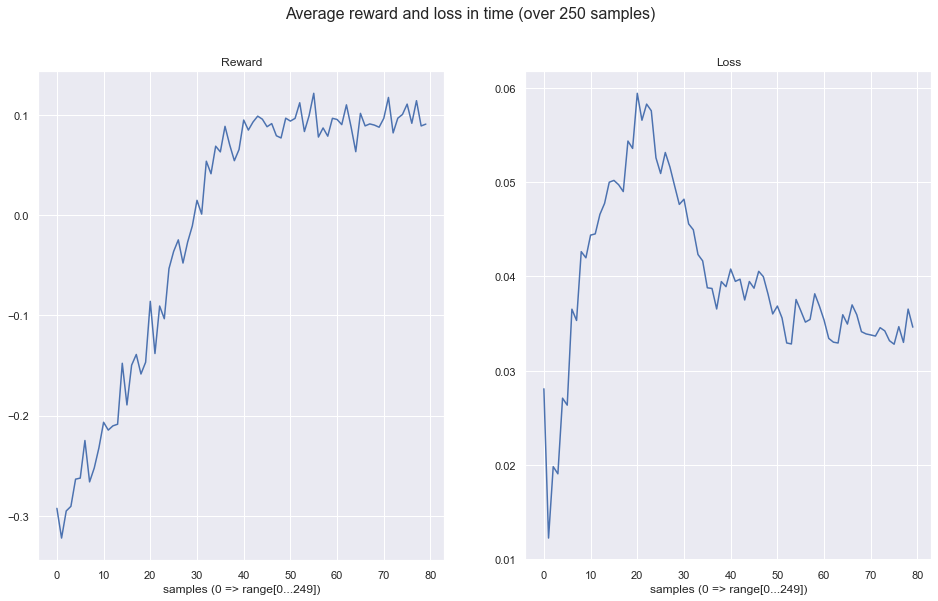

In [30]:
n_star_trainers[1].plot_avg_loss_reward()

Choose the best value of n∗ that you found. Run DQN against Opt(εopt) for different values of εopt for 20’000 games – switch the 1st player after every game. Choose several values of εopt from a reasonably wide interval between 0 to 1 – particularly, include εopt = 0.
Question 14. After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents 4
– for each value of εopt. Plot Mopt and Mrand over time. What do you observe? How can you explain it? Expected answer: A figure showing Mopt and Mrand over time for different values of εopt (caption length < 250 words).

In [31]:
n_star = 10_000

trainers_with_best_n_star = []
ops_epsilons = np.linspace(0, 1, 5)
for op_eps in ops_epsilons:
    agent_epsilon = 0.1
    dqn =DQN(device).to(device)
    batch_size = 64
    replay_memory = ReplayMemory(10_000, 10_000)
    temp_trainer = Trainer(
        dqn,
        OptimalPlayer(op_eps),
        EpsilonGreedy(dqn, DecreasingEpsilon(0.1, 0.8, n_star), 9, device, logger),
        replay_memory,
        batch_size=batch_size
    )
    trainers_with_best_n_star.append(temp_trainer)

In [32]:
for t in trainers_with_best_n_star:
    t.main_loop()

2022-06-06 21:51:20.198 | INFO     | trainer:main_loop:111 - Initialize Replay Memory: Started
100%|██████████| 10000/10000 [00:12<00:00, 794.74it/s]2022-06-06 21:51:32.578 | INFO     | trainer:main_loop:188 - Initialize Replay Memory: Done
2022-06-06 21:51:32.578 | INFO     | trainer:main_loop:189 - Training Loop: Start
  6%|▌         | 1152/20000 [36:57<10:04:48,  1.93s/it]
20001it [06:27, 51.65it/s]                            
2022-06-06 21:57:59.817 | INFO     | trainer:main_loop:217 - Training Loop: Done
2022-06-06 21:57:59.818 | INFO     | trainer:main_loop:111 - Initialize Replay Memory: Started
100%|█████████▉| 9981/10000 [00:09<00:00, 1067.08it/s]2022-06-06 21:58:09.330 | INFO     | trainer:main_loop:188 - Initialize Replay Memory: Done
2022-06-06 21:58:09.330 | INFO     | trainer:main_loop:189 - Training Loop: Start
100%|██████████| 10000/10000 [00:09<00:00, 1051.36it/s]
20001it [05:34, 59.84it/s]                            
2022-06-06 22:03:43.577 | INFO     | trainer:main_l

[autoreload of self_trainer failed: Traceback (most recent call last):
  File "/Users/adamnarozniak/Applications/anaconda3/envs/TicTacToe/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/adamnarozniak/Applications/anaconda3/envs/TicTacToe/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/adamnarozniak/Applications/anaconda3/envs/TicTacToe/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Users/adamnarozniak/Applications/anaconda3/envs/TicTacToe/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "/Users/adamnarozniak/Applications/anaconda3/envs/TicTacToe/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    upda

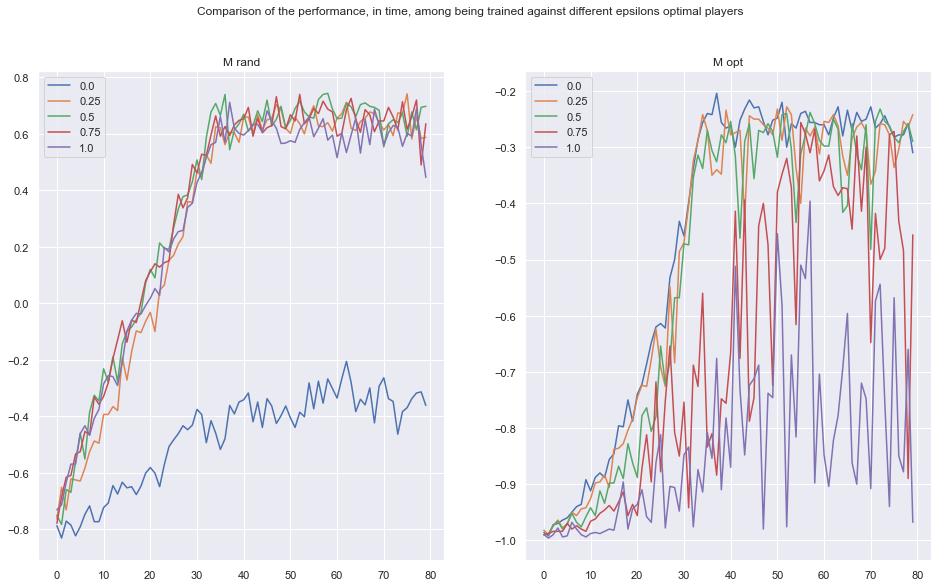

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.suptitle("Comparison of the performance, in time, among being trained against different epsilons optimal players")
ax1.set_title("M rand")
ax2.set_title("M opt")
for eps, t in zip(ops_epsilons, trainers_with_best_n_star):
    ax1.plot(list(range(len(t.m_rand))), t.m_rand, label=str(eps))
    ax1.legend()
    ax2.plot(list(range(len(t.m_opt))), t.m_opt, label=str(eps))
    ax2.legend()
    f.savefig("./../pictures/question14_mrand_mopt.png", dpi=300)

Question 15. What are the highest values of Mopt and Mrand that you could achieve after playing 20’000 games?

In [39]:
max_m_opt = -np.infty
max_m_rand = -np.infty
for eps, t in zip(ops_epsilons, trainers_with_best_n_star):
    max_m_opt = t.m_opt[-1] if t.m_opt[-1] > max_m_opt else max_m_opt
    max_m_rand = t.m_rand[-1] if t.m_rand[-1] > max_m_rand else max_m_rand
print(f"Max M opt is {max_m_opt}")
print(f"Max M rand is {max_m_rand}")


Max M opt is -0.242
Max M rand is 0.698


## Learning by self-practice

Question 16. After every 250 games during training, compute the ‘test’ Mopt and Mrand for different values of ε ∈ [0, 1). Plot Mopt and Mrand over time. Does the agent learn to play Tic Tac Toe? What is the effect of ε?
Expected answer: A figure showing Mopt and Mrand over time for different values of ε ∈ [0, 1) (caption length < 100 words).

In [67]:
ops_epsilons = np.linspace(0, 1, 5)
eps_self_practice_tr = []
for op_eps in ops_epsilons:
    dqn =DQN(device).to(device)
    batch_size = 64
    replay_memory = ReplayMemory(10_000, 64)
    trainer_self_practice = SelfPracticeTrainer(
        dqn,
        None,
        EpsilonGreedy(dqn, ConstantEpsilon(op_eps), 9, device, logger),
        replay_memory,
        batch_size=batch_size
    )
    eps_self_practice_tr.append(trainer_self_practice)

In [68]:
for t in eps_self_practice_tr:
    t.main_loop()

2022-06-07 00:26:57.049 | INFO     | self_trainer:main_loop:52 - Initialize Replay Memory: Started



  0%|          | 0/64 [00:00<?, ?it/s]2022-06-07 00:26:57.071 | INFO     | self_trainer:main_loop:166 - Initialize Replay Memory: Done
2022-06-07 00:26:57.072 | INFO     | self_trainer:main_loop:167 - Training Loop: Start
 50%|█████     | 32/64 [00:00<00:00, 1554.17it/s]



  0%|          | 0/20000 [00:00<?, ?it/s]


  0%|          | 51/20000 [00:00<00:39, 508.70it/s]


  1%|          | 102/20000 [00:00<00:41, 482.95it/s]


  1%|          | 151/20000 [00:00<00:46, 425.51it/s]


  1%|          | 195/20000 [00:00<00:51, 382.01it/s]


  1%|          | 234/20000 [00:00<00:53, 370.31it/s]


  1%|▏         | 272/20000 [00:02<06:46, 48.49it/s] 


  2%|▏         | 305/20000 [00:03<05:11, 63.24it/s]


  2%|▏         | 339/20000 [00:03<03:58, 82.54it/s]


  2%|▏         | 378/20000 [00:03<02:58, 110.19it/s]


  2%|▏         | 421/20000 [00:03<02:13, 146.52it/s]


  2%|▏         | 459/20000 [00:0

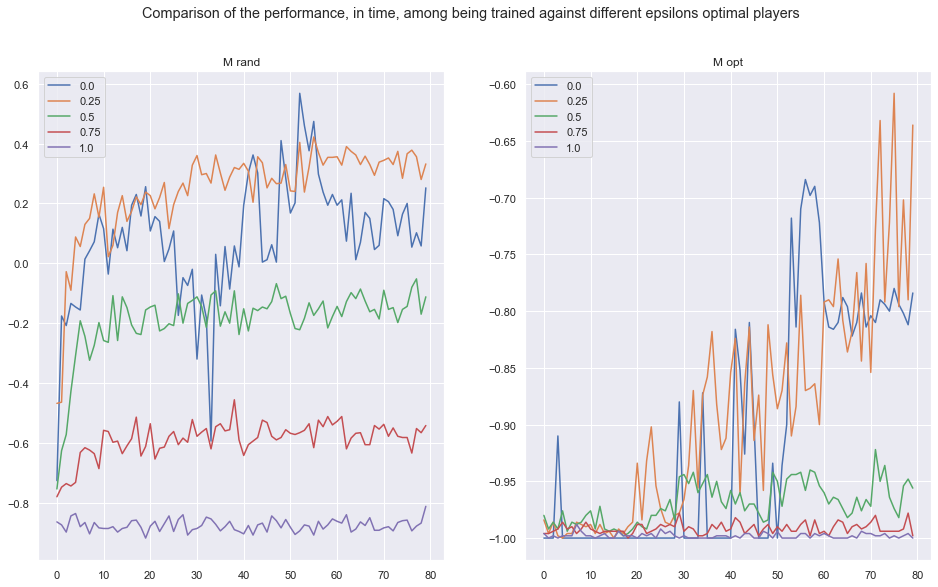

In [70]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.suptitle("Comparison of the performance, in time, among being trained against different epsilons optimal players")
ax1.set_title("M rand")
ax2.set_title("M opt")
for eps, t in zip(ops_epsilons, eps_self_practice_tr):
    ax1.plot(list(range(len(t.m_rand))), t.m_rand, label=str(eps))
    ax1.legend()
    ax2.plot(list(range(len(t.m_opt))), t.m_opt, label=str(eps))
    ax2.legend()
    f.savefig("./../pictures/question16_mrand_mopt.png", dpi=300)

Instead of fixing ε, use ε(n) in Equation 1 with different values of n∗.
Question 17. After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents. Plot Mopt and Mrand over time. Does decreasing ε help training compared to having a fixed ε? What is the effect of n∗?
Expected answer: A figure showing Mopt and Mrand over time for different values of speeds of n∗ (caption length < 100 words).

In [54]:
n_stars = np.linspace(1, 40_000, 5).astype(np.int32)
n_stars

array([    1, 10000, 20000, 30000, 40000], dtype=int32)

In [55]:
self_practice_eps_dec_trainers = []
for n_star in n_stars:
    dqn =DQN(device).to(device)
    batch_size = 64
    replay_memory = ReplayMemory(10_000, 64)
    temp_trainer = SelfPracticeTrainer(
        dqn,
        None,
        EpsilonGreedy(dqn, DecreasingEpsilon(0.1, 0.8, n_star), 9, device, logger),
        replay_memory,
        batch_size=batch_size
    )
    self_practice_eps_dec_trainers.append(temp_trainer)

In [57]:
for t in self_practice_eps_dec_trainers:
    t.main_loop()

2022-06-06 23:15:09.411 | INFO     | self_trainer:main_loop:52 - Initialize Replay Memory: Started





  0%|          | 0/64 [00:00<?, ?it/s]2022-06-06 23:15:09.436 | INFO     | self_trainer:main_loop:166 - Initialize Replay Memory: Done
2022-06-06 23:15:09.437 | INFO     | self_trainer:main_loop:167 - Training Loop: Start
 20%|██        | 13/64 [00:00<00:00, 577.21it/s]





  0%|          | 0/20000 [00:00<?, ?it/s]




  0%|          | 28/20000 [00:00<01:11, 279.39it/s]




  0%|          | 60/20000 [00:00<01:06, 297.81it/s]




  0%|          | 94/20000 [00:00<01:03, 315.18it/s]




  1%|          | 131/20000 [00:00<00:59, 335.65it/s]




  1%|          | 165/20000 [00:00<00:58, 336.97it/s]




  1%|          | 201/20000 [00:00<00:57, 343.45it/s]




  1%|          | 236/20000 [00:00<00:58, 338.60it/s]




  1%|▏         | 270/20000 [00:03<08:10, 40.21it/s] 




  2%|▏         | 302/20000 [00:03<06:03, 54.26it/s]




  2%|▏         | 335/20000 [00:03<04:30, 72.74it/s]




  2%|▏   

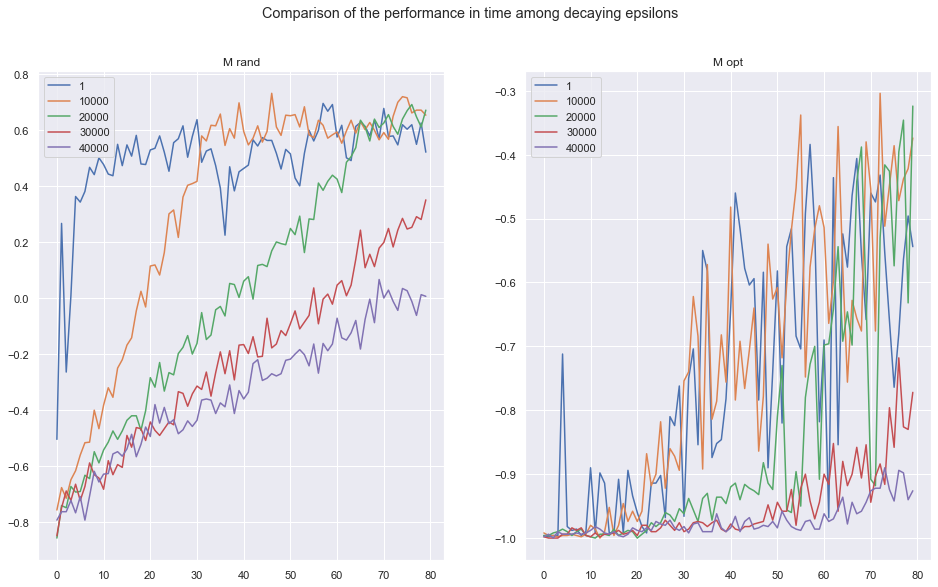

In [59]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.suptitle("Comparison of the performance in time among decaying epsilons")
ax1.set_title("M rand")
ax2.set_title("M opt")
for n_star, t in zip(n_stars, self_practice_eps_dec_trainers):
    ax1.plot(list(range(len(t.m_rand))), t.m_rand, label=str(n_star))
    ax1.legend()
    ax2.plot(list(range(len(t.m_opt))), t.m_opt, label=str(n_star))
    ax2.legend()
    f.savefig("./../pictures/question17_mrand_mopt.png", dpi=300)

Question 18. What are the highest values of Mopt and Mrand that you could achieve after playing 20’000 games?

In [60]:
max_m_opt = -np.infty
max_m_rand = -np.infty
for n_star, t in zip(n_stars, self_practice_eps_dec_trainers):
    max_m_opt = t.m_opt[-1] if t.m_opt[-1] > max_m_opt else max_m_opt
    max_m_rand = t.m_rand[-1] if t.m_rand[-1] > max_m_rand else max_m_rand
print(f"Max M opt is {max_m_opt}")
print(f"Max M rand is {max_m_rand}")

Max M opt is -0.324
Max M rand is 0.67


Question 19. For three board arrangements (i.e. states s), visualize Q-values of available actions (e.g. using heat maps). Does the result make sense? Did the agent learn the game well?
Expected answer: A figure with 3 subplots of 3 different states with Q-values shown at available actions (caption length < 200 words).

In [83]:
grid_1 = np.array((1,0,1,0,-1,-1,0,0,0)).reshape(3,3)
grid_2 = np.array((0,0,0,-1,-1,1,1,1,-1)).reshape(3,3)
grid_3 = np.array((-1,0,1,0,1,1,-1,1,-1)).reshape(3,3)

In [116]:
state_1 = represent_gird_as_state(grid_1, my_representation="X", device=self_practice_eps_dec_trainers[1].device)
state_2 = represent_gird_as_state(grid_2, my_representation="X", device=self_practice_eps_dec_trainers[1].device)
state_3 = represent_gird_as_state(grid_3, my_representation="O", device=self_practice_eps_dec_trainers[1].device)

In [117]:
with torch.no_grad():
    q_1 = self_practice_eps_dec_trainers[0].dqn(state_1).numpy()
    q_2 = self_practice_eps_dec_trainers[0].dqn(state_2).numpy()
    q_3 = self_practice_eps_dec_trainers[0].dqn(state_3).numpy()

In [118]:
env = TictactoeEnv()
env.grid = grid_1
env.render()
print("Move: X")

|X - X|
|- O O|
|- - -|

Move: X


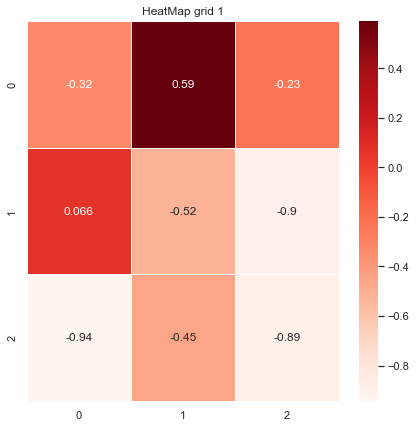

In [134]:
plt.figure(figsize=(7,7))
heat_map = sns.heatmap(q_1.reshape(3, 3), linewidth = 1 , annot = True, cmap='Reds')
plt.title( "HeatMap grid 1" )
plt.show()
f = heat_map.get_figure()
f.savefig("./../pictures/hm1.png", dpi=300)

In [135]:
env.grid = grid_2
env.render()
print("Move: X")

|- - -|
|O O X|
|X X O|

Move: X


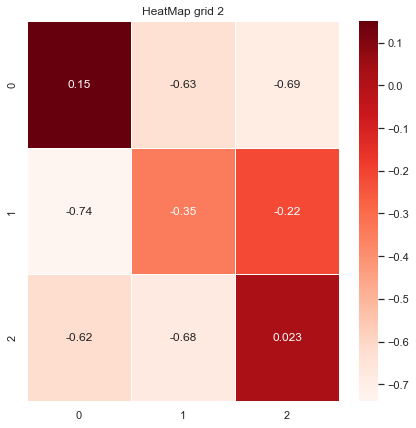

In [136]:
plt.figure(figsize=(7,7))
heat_map = sns.heatmap(q_2.reshape(3,3), linewidth = 1 , annot = True, cmap='Reds')
plt.title( "HeatMap grid 2" )
plt.show()
f = heat_map.get_figure()
f.savefig("./../pictures/hm2.png", dpi=300)

In [129]:
env.grid = grid_3
env.render()
print("Move: O")

|O - X|
|- X X|
|O X O|

Move: O


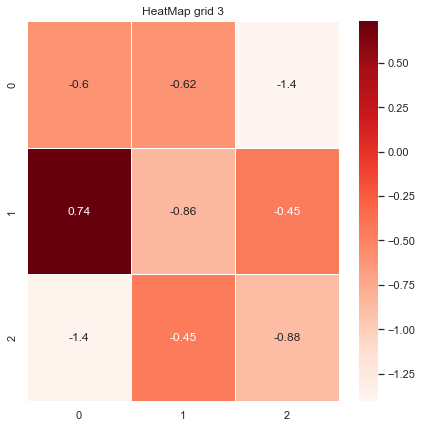

In [133]:
plt.figure(figsize=(7,7))
heat_map = sns.heatmap(q_3.reshape(3, 3), linewidth = 1 , annot = True, cmap='Reds')
plt.title( "HeatMap grid 3" )
plt.show()
f = heat_map.get_figure()
f.savefig("./../pictures/hm3.png", dpi=300)